## Calculate Action Spectra Statistics (Multiple Stim Wavelengths) for Multiple Cells


Hold the cell at -70 mV.\
(This is suitable for both neurons and HEK cells, although HEK cells will be quite happy to sit at a holding voltage of 0 mV.)

#### Protocol
Each run usually consists of a (rectangular) voltage step away from the expected reversal potential (see below) followed by a (rectangular) light stim at a particular wavelength (i.e. a particular LED). The light stim is fully contained within the voltage step (if there is a voltage step). For instance, the timings of the voltage and light stim ON and OFF steps might be: voltage-step ON at 3 sec, light-stim ON at 4 sec, light-stim OFF at 5 sec, voltage-step OFF at 6 sec. If the channel has slow kinetics (i.e. if the trace doesn't reach a baseline before voltage-OFF), then increase the time interval between light-OFF and voltage-OFF to record the full return to baseline.

In order to build up an Action Spectrum, this protocol sequence is repeated multiple times, changing the wavelength each time.

#### Why step the voltage prior to light stim?
Stepping the voltage prior to light stim is aimed at maximizing the change in current resulting from channel opening.\
Reversal potential for an *inhibitory channel* will be somewhere around -70 mV, so step the voltage to 0 mV (or thereabouts) prior to light stim.\
By contrast, reversal potential for an *excitatory channel* will be somewhere around 0 mV, so keep the voltage at -70 mV (or thereabouts) prior to light stim.

#### Calculations for both inhibitory and excitatory activity
This Jupyter notebook will calculate statistics from both inhibitory and excitatory light stim traces, based upon which direction the current trace moves after light stim. No manual adjustments are required to switch between calculating inhibitory or excitatory statistics.

### Import relevant modules

In [1]:
import pyabf
import numpy as np
import matplotlib.pyplot as plt
import scipy
import glob
import pandas as pd
import seaborn as sns
from scipy.optimize import curve_fit

### Set overall variables
The file_trunk is used in filenames for saving dataframes and charts. Here, the format is: "experimentDateYYYYMMDD_cellType_proteinName_"

In [2]:
file_trunk = '20220505_HEK_KCR_'

### Create list of all abf files with "step_hold" in their protocol name
N.B. "step_hold" is specific to inhibitory protocols... for excitatory can use "stim1sec"...

In [349]:
# generate list of files from current directory ending in ".abf"
list_of_files = sorted(glob.glob("*.abf"))

# Create list of only those abf files that have "step_hold" in their protocol name
spectrumlist = []
for file in list_of_files:
    abf = pyabf.ABF(file)
    fullstring = abf.protocol
    substring1 = "step_hold"  # specific to inhibitory protocols (includes a +70 mV voltage step)
    substring2 = "stim1sec"   # specific to excitatory protocols (does not include a voltage step)
    if substring1 in fullstring:      # Search for substring1 in the fullstring
        spectrumlist.append(file)     # Add the filename to the list
    if substring2 in fullstring:      # Search for substring2 in the fullstring
        spectrumlist.append(file)     # Add the filename to the list
        
# Display the list
display(spectrumlist)

['20220408_0002.abf',
 '20220408_0003.abf',
 '20220408_0004.abf',
 '20220408_0005.abf',
 '20220408_0006.abf',
 '20220408_0007.abf',
 '20220408_0034.abf',
 '20220408_0035.abf',
 '20220408_0036.abf',
 '20220408_0037.abf',
 '20220408_0038.abf',
 '20220408_0039.abf',
 '20220408_0090.abf',
 '20220408_0091.abf',
 '20220408_0092.abf',
 '20220408_0093.abf',
 '20220408_0094.abf',
 '20220408_0095.abf',
 '20220415_0059.abf',
 '20220415_0060.abf',
 '20220415_0061.abf',
 '20220415_0062.abf',
 '20220415_0063.abf',
 '20220415_0064.abf',
 '20220415_0075.abf',
 '20220415_0076.abf',
 '20220415_0077.abf',
 '20220415_0078.abf',
 '20220415_0079.abf',
 '20220415_0080.abf',
 '20220505_0002.abf',
 '20220505_0003.abf',
 '20220505_0004.abf',
 '20220505_0005.abf',
 '20220505_0006.abf',
 '20220505_0007.abf',
 '20220505_0010.abf',
 '20220505_0011.abf',
 '20220505_0012.abf',
 '20220505_0013.abf',
 '20220505_0014.abf',
 '20220505_0015.abf']

### Remove unwanted files from list

In [337]:
#spectrumlist.remove('20220407_0002.abf')
#spectrumlist.remove('20220407_0003.abf')
#spectrumlist.remove('20220407_0004.abf')
#spectrumlist.remove('20220407_0005.abf')
#spectrumlist.remove('20220407_0006.abf')
#spectrumlist.remove('20220407_0007.abf')
#len(spectrumlist)

### Read out summary information of a single abf file

In [338]:
file = spectrumlist[3]
abf = pyabf.ABF(file)
abf

ABF (v2.6) with 3 channels (pA, pA, V), sampled at 20.0 kHz, containing 1 sweep, having no tags, with a total length of 0.38 minutes, recorded with protocol "5_VC_teal_step_hold". path=/Users/efxbyrne/Library/CloudStorage/GoogleDrive-efxbyrne@stanford.edu/My Drive/project_KCR/data_ephys/Jupyter_LatestAnalyses_templates/action_spectra/20220408_0005.abf

### Define module for plotting all channels in a run

In [343]:
def plot_multichannelabf(abf_filename, xaxis_min=0, xaxis_max=0, lightstim_starttime=10.8594, lightstim_endtime=11.8594):
    """For an abf file with multiple channels, plot each channel one on top of the other. 
    Need to manually set light-stim time boundaries because different protocols have different 
    settings for the light stim epoch."""
    
    # Load file to plot.
    abf = pyabf.ABF(abf_filename)
    
    # Voltage-step epoch: extract the start and end time.
    channelNumber = 0
    epochNumber = 4
    abf.setSweep(sweepNumber=0, channel=channelNumber)
    try:
        v1 = abf.sweepEpochs.p1s[epochNumber] * abf.dataSecPerPoint   # start of epoch, converted to time (in sec)
        v2 = abf.sweepEpochs.p2s[epochNumber] * abf.dataSecPerPoint   # end of epoch, converted to time (in sec)
    except:
        v1 = 10.359350000000001
        v2 = 12.359350000000001
        
    # Light-stim epoch: extract the start and end time.
    l1 = lightstim_starttime
    l2 = lightstim_endtime

    # Set other periods for calculations.
    b1 = l1 - 0.201 # pre-light stim baseline, start time
    b2 = l1 - 0.001 # pre-light stim baseline, end time
    k1 = l2 - 0.101 # last 100 ms of light stim, start time
    k2 = l2 - 0.001 # last 100 ms of light stim, end time
    
    # List of channels to plot.
    ycol = abf.channelList
    nSubplots = len(ycol)
    nSubplots_list = np.arange(0,len(ycol))

    # Plot the data from each sweep.
    f, axs = plt.subplots(nSubplots, 1, figsize=(8, (nSubplots*2.5)), sharey=False, sharex=True)
    for i,j in zip(ycol, nSubplots_list):
        abf.setSweep(sweepNumber=0, channel=i)
        sns.lineplot(x=abf.sweepX, y=abf.sweepY, ax=axs[j], label="Channel " + str(i))
        if i == 0:
            axs[j].set_ylabel(abf.sweepLabelC)
            axs[j].set_title(abf_filename)
        else:
            axs[j].set_ylabel(abf.sweepLabelY)
        axs[j].set_xlabel(abf.sweepLabelX)
        if xaxis_max == 0:
            axs[j].set_xlim(auto=True)
        else:
            axs[j].set_xlim(xaxis_min, xaxis_max)
        axs[j].axvspan(v1,v2, color='k', alpha=.1, label="voltage step")
        axs[j].axvspan(l1,l2, color='y', alpha=.2, label="light stim")
        axs[j].axvspan(b1,b2, color='b', alpha=.1, label="pre-light on")
        axs[j].axvspan(k1,k2, color='g', alpha=.1, label="pre-light off")
        axs[j].legend(loc="upper right")

    # Seaborn formatting
    f.tight_layout()
    sns.despine(fig=f)
    print('KEY TIME PERIODS:')
    print(f'Voltage step: {v1} to {v2} sec')
    print(f'Light stim: {l1} to {l2} sec')
    print(f'Baseline pre-light on: {b1} to {b2} sec')
    print(f'Baseline pre-light off: {k1} to {k2} sec')


### Plot an example of step_hold run
This is to check that the voltage step and light stime epochs are found correctly for this protocol, before proceeding with calculations.

KEY TIME PERIODS:
Voltage step: 10.359350000000001 to 12.359350000000001 sec
Light stim: 10.8594 to 11.8594 sec
Baseline pre-light on: 10.6584 to 10.858400000000001 sec
Baseline pre-light off: 11.7584 to 11.858400000000001 sec


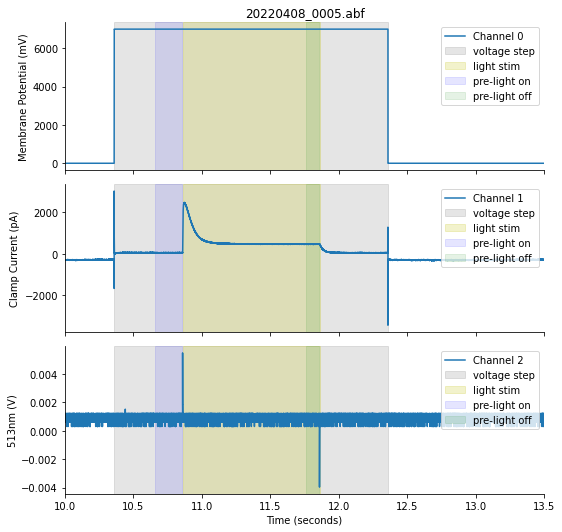

In [355]:
plot_multichannelabf(abf_filename=spectrumlist[3], xaxis_min=10, xaxis_max=13.5)

### Define modules to calculate, display and plot action spectrum statistics


In [364]:
def monoExp(x, m, t, b):  
    """Single exponential decay function."""
    return m * np.exp(-t * x) + b
    
def lightstimstats(abf_filename, rate_hz=10000, lightstim_starttime=10.8594, lightstim_endtime=11.8594):
    """Calculate light stim statistics for a single input file."""
    # abf_filename : input file
    # rate_hz : the dataRate in Hz (points per sec)
    # dV : delta/change of the voltage (the size of the voltage step, determined by the stim protocol)
    # lightstim_starttime : manual entry of start of light-stim epoch
    # lightstim_endtime : manual entry of end of light-stim epoch
    
    # Load file to plot.
    abf = pyabf.ABF(abf_filename)
    rate_hz = abf.dataRate
    
    # This dictionary is what gets returned at the end.
    stats_dict={"Run ID":abf.abfID}
    stats_dict["Date Time"] = str(abf.abfDateTime)
    stats_dict["Protocol"] = abf.protocol
    stats_dict["Wavelength"] = abf.adcNames[2]
    
    # Voltage-step epoch: extract the start and end time.
    channelNumber = 0
    epochNumber = 4
    abf.setSweep(sweepNumber=0, channel=channelNumber)
    try:
        v1 = abf.sweepEpochs.p1s[epochNumber] * abf.dataSecPerPoint   # start of epoch, converted to time (in sec)
        v2 = abf.sweepEpochs.p2s[epochNumber] * abf.dataSecPerPoint   # end of epoch, converted to time (in sec)
    except:
        v1 = 10.359350000000001
        v2 = 12.359350000000001
    
    # Light-stim epoch: extract the start and end time.
    l1 = lightstim_starttime
    l2 = lightstim_endtime

    # Set other periods for calculations.
    b1 = l1 - 0.201   # pre-light stim baseline, start time
    b2 = l1 - 0.001   # pre-light stim baseline, end time
    k1 = l2 - 0.101   # last 100 ms of light stim, start time
    k2 = l2 - 0.001   # last 100 ms of light stim, end time
    
    # Convert timing periods to datapoints for calculations.
    l1_datapoints = int(l1 * rate_hz)   # light stim start time, in datapoints
    l2_datapoints = int(l2 * rate_hz)   # light stim end time, in datapoints
    k1_datapoints = int(k1 * rate_hz)   # last 100 ms of light stim, start time, in datapoints
    k2_datapoints = int(k2 * rate_hz)   # last 100 ms of light stim, end time, in datapoints
    v1_datapoints = int(v1 * rate_hz)   # voltage step start, in datapoints
    v2_datapoints = int(v2 * rate_hz)   # voltage step end, in datapoints
    
    # Set sweep for calculations (need y-axis to be photocurrent).
    channelNumber = 1
    abf.setSweep(sweepNumber=0, channel=channelNumber, baseline=[b1,b2]) # N.B. baseline units need to be in seconds (so don't convert to datapoints)
    
    # Check for excitatory activity.
    if np.mean(abf.sweepY[l1_datapoints:(l1_datapoints+100)]) < 0:   # if the trace goes downwards after light stim ON (i.e. excitatory channel activity)
        # then flip the y-data across the x-axis (* -1) so that the following analysis is the same
        Yl = -1 * np.array(abf.sweepY[l1_datapoints:l2_datapoints])   # N.B. abf.sweepY is in units datapoints
        Yk = -1 * np.array(abf.sweepY[k1_datapoints:k2_datapoints])
        Yp = -1 * np.array(abf.sweepY[l2_datapoints:v2_datapoints])
        excitatory = True
        dV = 0 *1e-3 # dV is in units Volts
    else:      # if the trace goes upwards after light stim ON (i.e. inhibitory channel activity)
        Yl = np.array(abf.sweepY[l1_datapoints:l2_datapoints])   # N.B. abf.sweepY is in units datapoints
        Yk = np.array(abf.sweepY[k1_datapoints:k2_datapoints])
        Yp = np.array(abf.sweepY[l2_datapoints:v2_datapoints])
        excitatory = False
        dV = 70 *1e-3 # dV is in units Volts
        
    stats_dict['Excitatory?'] = excitatory
    stats_dict["dV"] = dV*1e3   # dV is in units Volts, "*1e3" to convert to milliVolts (mV)
    
    ## PERIOD 1: DURING LIGHT-STIM (i.e. between L1 and L2)
    # Make arrays for x and y values:
    Xl = np.array(abf.sweepX[l1_datapoints:l2_datapoints])   # N.B. abf.sweepX is in units datapoints
    
    # Calculate peak current.
    peakcurrent = np.amax(Yl)*1e-12  # peakcurrent is in Amps ("*1e-12" converts pA to A)     
    stats_dict['Peak photocurrent (nA)'] = peakcurrent *1e9  # peakcurrent is in units Amps, "*1e9" to convert to nanoAmps (nA)
    
    # Calculate time-to-peak: find X (time) at max Y (photocurrent).
    X_atMaxY = Xl[np.argmax(Yl)]
    timeToPeak = (X_atMaxY - l1)   # timeToPeak is in seconds
    stats_dict['Time to peak (ms)'] = timeToPeak *1e3  # timeToPeak is in units seconds, "*1e3" to convert to milliseconds (ms)
    
    # Calculate tau-off from peak current to steady-state.
    # make new arrays starting from maximum Y value (argmax) i.e. peak photocurrent
    Yl_fromMaxY = Yl[np.argmax(Yl):]
    Xl_fromMaxY = Xl[np.argmax(Yl):]
    tau1_dict={"Xl":Xl}
    tau1_dict["Yl"] = Yl
    tau1_dict["Xl_fromMaxY"] = Xl_fromMaxY
    # Calculate the tau value and fit; perform the fit:
    try:        # placed inside try/except because sometimes a fit cannot be found in the given maxfev
        p0_l = (1000, 0.1, 1000)   # start with values near those we expect
        params_l, cv = scipy.optimize.curve_fit(monoExp, Xl_fromMaxY, Yl_fromMaxY, p0_l, maxfev=30000)
        m_l, t_l, b_l = params_l
        tau_light = (1 / t_l)    # tau_light is in units seconds
        # determine quality of the fit:
        squaredDiffs = np.square(Yl_fromMaxY - monoExp(Xl_fromMaxY, m_l, t_l, b_l))
        squaredDiffsFromMean = np.square(Yl_fromMaxY - np.mean(Yl_fromMaxY))
        rSquared_light = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
        stats_dict["Tau-off1 (ms)"] = tau_light*1e3      # tau_light is in units seconds, "*1e3" to convert to milliSec (ms)
        stats_dict["R² for Tau-off1"] = rSquared_light
        tau1_dict["m_l"] = m_l
        tau1_dict["b_l"] = b_l
        tau1_dict["t_l"] = t_l
    except:
        pass

    
    ## PERIOD 2: Last 100 ms of LIGHT-STIM (i.e. between K1 and K2)
    # Calculate steady-state photocurrent.
    steadycurrent = np.mean(Yk)*1e-12  # find mean for the array of sweepY values between k1 and k2; steadycurrent is in Amps ("*1e-12" converts pA to A) 
    stats_dict['Steady-state photocurrent (nA)'] = steadycurrent *1e9  # steadycurrent is in units Amps, "*1e9" to convert to nanoAmps (nA)

    # Calculate ratio between steady-state and peak photocurrents
    ratio_sp = steadycurrent/peakcurrent    # no units (both steadycurrent and peakcurrent in units Amps)
    stats_dict['Ratio steady-to-peak'] = ratio_sp  # no units
    
    
    ## PERIOD 3: AFTER LIGHT-STIM  (i.e. between L2 and V2)
    # Calculate tau-off from peak current to steady-state.
    # Make arrays for x and y values:
    Xp = np.array(abf.sweepX[l2_datapoints:v2_datapoints])
    # make new arrays starting from maximum Y value (argmax) i.e. peak photocurrent
    Yp_fromMaxY = Yp[np.argmax(Yp):]
    Xp_fromMaxY = Xp[np.argmax(Yp):]
    tau2_dict={"Xp":Xp}
    tau2_dict["Yp"] = Yp
    tau2_dict["Xp_fromMaxY"] = Xp_fromMaxY
    # perform the fit
    try:      # placed inside try/except because sometimes a fit cannot be found in the given maxfev
        p0_p = (1000, 0.1, 30) # start with values near those we expect
        params_p, cv = scipy.optimize.curve_fit(monoExp, Xp_fromMaxY, Yp_fromMaxY, p0_p, maxfev=30000)
        m_p, t_p, b_p = params_p
        tau_postlight = (1 / t_p)    # tau_postlight is in units seconds
        # determine quality of the fit
        squaredDiffs = np.square(Yp_fromMaxY - monoExp(Xp_fromMaxY, m_p, t_p, b_p))
        squaredDiffsFromMean = np.square(Yp_fromMaxY - np.mean(Yp_fromMaxY))
        rSquared_postlight = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
        stats_dict["Tau-off2 (ms)"] = tau_postlight*1e3      # tau_postlight is in units seconds, "*1e3" to convert to milliSec (ms)
        stats_dict["R² for Tau-off2"] = rSquared_postlight
        tau2_dict["m_p"] = m_p
        tau2_dict["b_p"] = b_p
        tau2_dict["t_p"] = t_p
    except:
        pass
    
    return stats_dict, tau1_dict, tau2_dict

def display_lightstimstats(stats_dict):
    """Given a lightstimstats dictionary, show the important stuff with its units."""
    print("Run ID: " + stats_dict["Run ID"])
    print("Date Time: " + stats_dict["Date Time"])
    print("Protocol: " + stats_dict["Protocol"])
    print("Wavelength: " + stats_dict["Wavelength"])
    print("Voltage step: %.02f mV"%(stats_dict["dV"]))
    print("Excitatory?: " + str(stats_dict["Excitatory?"]))
    print("Peak photocurrent: %.03f nA"%(stats_dict["Peak photocurrent (nA)"]))
    print("Time to peak: %.02f ms"%(stats_dict["Time to peak (ms)"]))
    print("Steady-state photocurrent: %.03f nA"%(stats_dict["Steady-state photocurrent (nA)"]))
    print("Ratio steady-to-peak: %.02f"%(stats_dict["Ratio steady-to-peak"]))
    try:
        print("Tau-off1 (ms): %.03f ms"%(stats_dict["Tau-off1 (ms)"]))
        print("Tau-off1 R² (peak-to-steadystate):  %.03f"%(stats_dict["R² for Tau-off1"]))
        print("Tau-off2 (ms): %.03f ms"%(stats_dict["Tau-off2 (ms)"]))
        print("Tau-off2 R² (peak-to-steadystate):  %.03f"%(stats_dict["R² for Tau-off2"]))
    except:
        print("Tau-off1 (ms): calculation error")
        print("Tau-off1 R² (peak-to-steadystate):  calculation error")
        print("Tau-off2 (ms): calculation error")
        print("Tau-off2 R² (peak-to-steadystate):  calculation error")

def plot_lightstimstats(stats_dict, tau1_dict, tau2_dict, savefig=False):
    """Plot the lightstimstats curves to show the goodness of fit."""
    fig = plt.figure(figsize=(15, 5))
    plt.plot((tau1_dict["Xl"]),(tau1_dict["Yl"]), '.', label="during light stim, data")
    plt.plot((tau2_dict["Xp"]), (tau2_dict["Yp"]), '.', label="after light stim, data")
    try:
        plt.plot((tau1_dict["Xl_fromMaxY"]), monoExp((tau1_dict["Xl_fromMaxY"]), (tau1_dict["m_l"]), (tau1_dict["t_l"]), (tau1_dict["b_l"])), '--', label="during light stim, fitted")
    except:
        pass
    try:
        plt.plot((tau2_dict["Xp_fromMaxY"]), monoExp((tau2_dict["Xp_fromMaxY"]), (tau2_dict["m_p"]), (tau2_dict["t_p"]), (tau2_dict["b_p"])), '--', label="after light stim, fitted")
    except:
        pass
    plt.ylabel("Current (pA)")
    plt.xlabel("Time (sec)")
    plt.title(stats_dict["Run ID"] + " " + stats_dict["Protocol"] + " tau-fit")
    if savefig==True:
        plt.savefig(stats_dict["Run ID"] + "_" + stats_dict["Protocol"] + "_tau-fit" +'.png')
    plt.legend()
    plt.show()
    

### Calculate light stim statistics for single run

Run ID: 20220415_0064
Date Time: 2022-04-15 12:32:21.671000
Protocol: 7_VC_red_stim1sec
Wavelength: 650nm
Voltage step: 0.00 mV
Excitatory?: True
Peak photocurrent: 0.120 nA
Time to peak: 878.70 ms
Steady-state photocurrent: 0.099 nA
Ratio steady-to-peak: 0.83
Tau-off1 (ms): calculation error
Tau-off1 R² (peak-to-steadystate):  calculation error
Tau-off2 (ms): calculation error
Tau-off2 R² (peak-to-steadystate):  calculation error


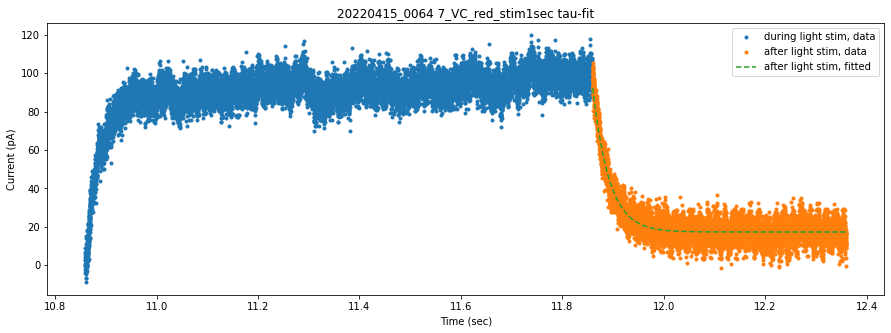

In [365]:
# Enter an abf file:
file = spectrumlist[23]

# Run calculations.
stats_dict, tau1_dict, tau2_dict = lightstimstats(file)

# Display key statistics.
display_lightstimstats(stats_dict)

# Plot chart of key part of curve.
plot_lightstimstats(stats_dict, tau1_dict, tau2_dict)

### Define module for calculating light stim statistics for multiple runs, putting the results into a dataframe

In [334]:
def multirun_lightstimstats(lightstim_list, makeplots=False, savefigs=False):
    """Enter a list of lightstim files to calculate statistics for all of them."""
    
    # Create dataframe for storing output values.
    df_spectrum = pd.DataFrame()

    # Iterate across each file in the list.
    for i,j in zip(lightstim_list, np.arange(0,len(lightstim_list))):

        # Run calculations.
        stats_dict, tau1_dict, tau2_dict = lightstimstats(i)

        # Put stats_dict into a dataframe.
        df_stats_dict = pd.DataFrame([stats_dict], index=[j])
        
        # Append this dataframe to main dataframe.
        df_spectrum = pd.concat([df_spectrum,df_stats_dict], )
        
        if makeplots==True:
            # Plot chart of key part of curve.
            plot_lightstimstats(stats_dict, tau1_dict, tau2_dict, savefig=savefigs)
            
    return df_spectrum


### Calculate light stim statistics for list of two runs (small test case)

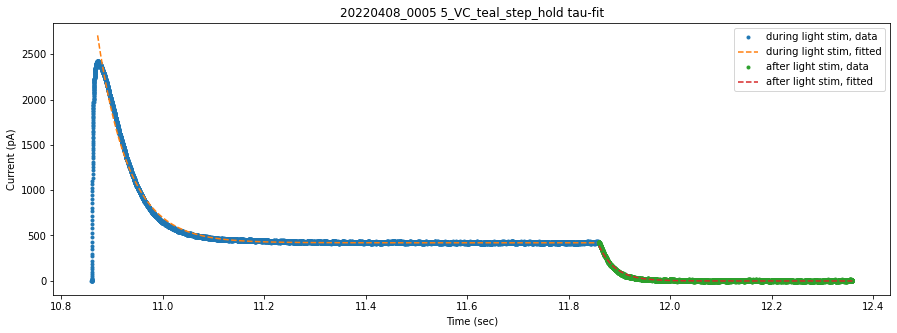

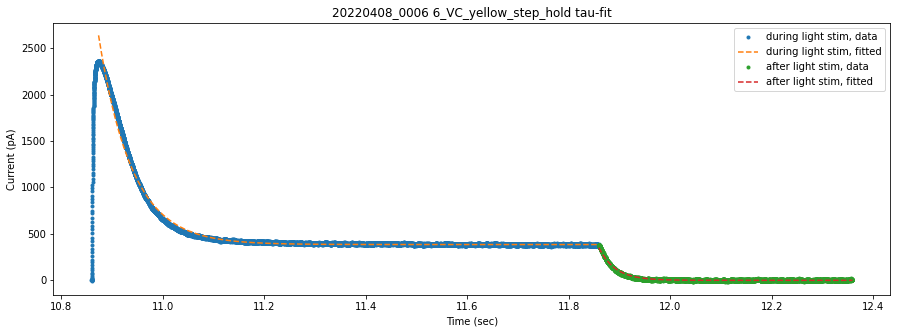

,dV,Run ID,Date Time,Protocol,Wavelength,Excitatory?,Peak photocurrent (nA),Time to peak (ms),Tau-off1 (ms),R² for Tau-off1,Steady-state photocurrent (nA),Ratio steady-to-peak,Tau-off2 (ms),R² for Tau-off2
0,70.0,20220408_0005,2022-04-08 11:38:25.144000,5_VC_teal_step_hold,513nm,False,2.425359,12.05,60.847878,0.994370,0.418357,0.172493,32.169943,0.981609
1,70.0,20220408_0006,2022-04-08 11:38:48.807000,6_VC_yellow_step_hold,560nm,False,2.361407,13.95,65.077179,0.994014,0.377902,0.160032,32.167769,0.980765


In [335]:
# Create input list of filenames to calculate statistics for.
spectrumlist_short = [spectrumlist[3], spectrumlist[4]]

# Run module with input list.
multirun_lightstimstats(spectrumlist_short, makeplots=True)

## Calculate light stim statistics for all files in spectrumlist
Calculate light stim statistics for all files in spectrumlist and put all into a dataframe.

In [366]:
# Run module with input list to calculate all statistics for all input files and output into a dataframe.
df_spectrum = multirun_lightstimstats(spectrumlist, makeplots=False)

In [367]:
# Display the output dataframe.
display(df_spectrum)

,Run ID,Date Time,Protocol,Wavelength,Excitatory?,dV,Peak photocurrent (nA),Time to peak (ms),Tau-off1 (ms),R² for Tau-off1,Steady-state photocurrent (nA),Ratio steady-to-peak,Tau-off2 (ms),R² for Tau-off2
0,20220408_0002,2022-04-08 11:37:14.108000,2_VC_violet_step_hold,390nm,False,70.0,1.697412,35.50,1.435751e+02,0.997918,0.486594,0.286668,32.158087,0.968735
1,20220408_0003,2022-04-08 11:37:37.778000,3_VC_blue_step_hold,438nm,False,70.0,1.910939,29.50,2.027661e+02,0.994989,0.626736,0.327973,32.160116,0.973285
2,20220408_0004,2022-04-08 11:38:01.456000,4_VC_cyan_step_hold,485nm,False,70.0,2.213135,19.25,6.425849e+01,0.996441,0.348833,0.157619,32.168409,0.977419
3,20220408_0005,2022-04-08 11:38:25.144000,5_VC_teal_step_hold,513nm,False,70.0,2.425359,12.05,6.084788e+01,0.994370,0.418357,0.172493,32.169943,0.981609
4,20220408_0006,2022-04-08 11:38:48.807000,6_VC_yellow_step_hold,560nm,False,70.0,2.361407,13.95,6.507718e+01,0.994014,0.377902,0.160032,32.167769,0.980765
5,20220408_0007,2022-04-08 11:39:12.479000,7_VC_red_step_hold,650nm,False,70.0,0.451466,67.70,4.067683e+02,0.991616,0.233791,0.517848,32.170468,0.967526
6,20220408_0034,2022-04-08 13:12:23.321000,2_VC_violet_step_hold,390nm,False,70.0,0.348235,15.00,1.517944e+02,0.956895,0.217543,0.624700,32.150208,0.878391
7,20220408_0035,2022-04-08 13:12:47.097000,3_VC_blue_step_hold,438nm,False,70.0,0.386201,11.10,7.407997e+01,0.931626,0.233005,0.603325,32.157297,0.946269
8,20220408_0036,2022-04-08 13:13:10.801000,4_VC_cyan_step_hold,485nm,False,70.0,0.406042,8.35,3.921333e+01,0.962843,0.196016,0.482749,32.201295,0.959124
9,20220408_0037,2022-04-08 13:13:34.570000,5_VC_teal_step_hold,513nm,False,70.0,0.421216,7.00,2.953359e+01,0.946340,0.208669,0.495398,32.237084,0.946578


### Add columns to the dataframe for cell labels (manual annotation)


In [368]:
# Add extra columns manually (write lists, add lists to dataframe)       
cellpatchID = []  # For a particular date, what number cell does each run correspond to?
cellpatchID += 6 * ['01']
cellpatchID += 6 * ['05']  
cellpatchID += 6 * ['13']
cellpatchID += 6 * ['08']
cellpatchID += 6 * ['10']
cellpatchID += 6 * ['01']  
cellpatchID += 6 * ['02']

construct = []    # What is the protein variant's name?
construct += 1* 6 * ['mutantX']
construct += 1* 6 * ['mutantY']
construct += 1* 6 * ['mutantZ']
construct += 1* 6 * ['mutantA_excit']
construct += 1* 6 * ['mutantB_excit']
construct += 2* 6 * ['mutantQ']

# Add the lists to the dataframe as new columns
df_spectrum["Cell patch ID"] = cellpatchID
df_spectrum["Construct"] = construct

# Make a unique cell ID by combining the date with the cellpatchID => into new column "Date_Cell"
df_spectrum['Date'] = df_spectrum['Date Time'].str.replace(r'\ .*', '', regex=True).replace(r'\-', '', regex=True) # pull out date from "Date Time"
df_spectrum['Date_Cell'] = df_spectrum['Date'] + "_" + df_spectrum['Cell patch ID'].astype(str) # combine "Date" and "Cell patch ID"
df_spectrum

# Display the dataframe
display(df_spectrum)

,Run ID,Date Time,Protocol,Wavelength,Excitatory?,dV,Peak photocurrent (nA),Time to peak (ms),Tau-off1 (ms),R² for Tau-off1,Steady-state photocurrent (nA),Ratio steady-to-peak,Tau-off2 (ms),R² for Tau-off2,Cell patch ID,Construct,Date,Date_Cell
0,20220408_0002,2022-04-08 11:37:14.108000,2_VC_violet_step_hold,390nm,False,70.0,1.697412,35.50,1.435751e+02,0.997918,0.486594,0.286668,32.158087,0.968735,01,mutantX,20220408,20220408_01
1,20220408_0003,2022-04-08 11:37:37.778000,3_VC_blue_step_hold,438nm,False,70.0,1.910939,29.50,2.027661e+02,0.994989,0.626736,0.327973,32.160116,0.973285,01,mutantX,20220408,20220408_01
2,20220408_0004,2022-04-08 11:38:01.456000,4_VC_cyan_step_hold,485nm,False,70.0,2.213135,19.25,6.425849e+01,0.996441,0.348833,0.157619,32.168409,0.977419,01,mutantX,20220408,20220408_01
3,20220408_0005,2022-04-08 11:38:25.144000,5_VC_teal_step_hold,513nm,False,70.0,2.425359,12.05,6.084788e+01,0.994370,0.418357,0.172493,32.169943,0.981609,01,mutantX,20220408,20220408_01
4,20220408_0006,2022-04-08 11:38:48.807000,6_VC_yellow_step_hold,560nm,False,70.0,2.361407,13.95,6.507718e+01,0.994014,0.377902,0.160032,32.167769,0.980765,01,mutantX,20220408,20220408_01
5,20220408_0007,2022-04-08 11:39:12.479000,7_VC_red_step_hold,650nm,False,70.0,0.451466,67.70,4.067683e+02,0.991616,0.233791,0.517848,32.170468,0.967526,01,mutantX,20220408,20220408_01
6,20220408_0034,2022-04-08 13:12:23.321000,2_VC_violet_step_hold,390nm,False,70.0,0.348235,15.00,1.517944e+02,0.956895,0.217543,0.624700,32.150208,0.878391,05,mutantY,20220408,20220408_05
7,20220408_0035,2022-04-08 13:12:47.097000,3_VC_blue_step_hold,438nm,False,70.0,0.386201,11.10,7.407997e+01,0.931626,0.233005,0.603325,32.157297,0.946269,05,mutantY,20220408,20220408_05
8,20220408_0036,2022-04-08 13:13:10.801000,4_VC_cyan_step_hold,485nm,False,70.0,0.406042,8.35,3.921333e+01,0.962843,0.196016,0.482749,32.201295,0.959124,05,mutantY,20220408,20220408_05
9,20220408_0037,2022-04-08 13:13:34.570000,5_VC_teal_step_hold,513nm,False,70.0,0.421216,7.00,2.953359e+01,0.946340,0.208669,0.495398,32.237084,0.946578,05,mutantY,20220408,20220408_05


### Plot all action spectrum statistics to compare within and between categories
The categories here are the wavelengths.

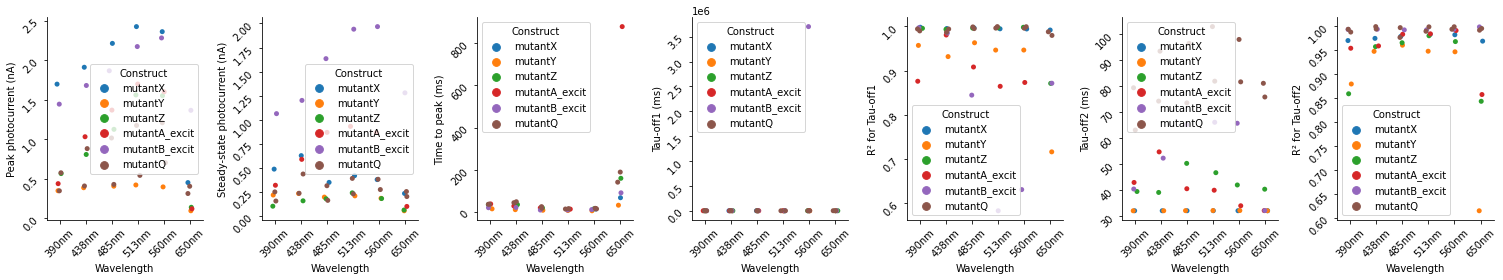

In [369]:
# Set category column for X-axis
xcol = "Wavelength"

# Set category column for hue (the color of the dots)
zcol = 'Construct' # or 'Date_Cell'

# List of statistics (column names) to plot
ycol = ['Peak photocurrent (nA)', 
        'Steady-state photocurrent (nA)',
        'Time to peak (ms)',
        'Tau-off1 (ms)',
        'R² for Tau-off1',
        'Tau-off2 (ms)', 
        'R² for Tau-off2',
        # add more statistics' names here for more plots
       ]
nSubplots = len(ycol)
nSubplots_list = np.arange(0,len(ycol))

# Plot the data from each column in the dataframe
f, axs = plt.subplots(1, nSubplots, figsize=((nSubplots*3), 4), sharey=False)
for i,j in zip(ycol, nSubplots_list):
    sns.stripplot(data=df_spectrum, x=xcol, y=i, hue=zcol, ax=axs[j])
    axs[j].tick_params(labelrotation=45)

# Seaborn formatting
f.tight_layout()
sns.despine(fig=f)

### Save figure as a png file

In [326]:
f.figure.savefig(file_trunk + "actionspectra_stats.png")

## Export dataframe to csv files

In [40]:
file_branch = 'actionspectra_'

### Export dataframe, long-form:

In [60]:
# Export dataframe to csv file.
df_spectrum.to_csv(file_trunk + file_branch + 'stats_longform.csv', index=False)

print('Wrote full dataframe to csv. Long-form: each row is one cell at one wavelength, each column is one statistic.')

Wrote full dataframe to csv. Long-form: each row is one cell at one wavelength, each column is one statistic.


### Export dataframe by components, wide-form:

In [327]:
# Set up features for rearranging dataframe into pivot tables.
pivot_index = 'Wavelength'
pivot_columns = 'Date_Cell'
pivot_values_list = ['Construct', 
                     'Peak photocurrent (nA)', 
                     'Steady-state photocurrent (nA)', 
                     'Ratio steady-to-peak', 
                     'Time to peak (ms)',
                     'Tau-off1 (ms)',
                     'R² for Tau-off1',
                     'Tau-off2 (ms)',
                     'R² for Tau-off2',
                     # add more statistics' names here for more tables
              ]

# Convert to pivot table and export to csv:
for i in pivot_values_list:
    df_spectrum_wide = df_spectrum.pivot(index=pivot_index, columns=pivot_columns, values=i)
    df_spectrum_wide.to_csv(file_trunk + file_branch + i + '_stats_wideform.csv', index=True)
    
print('Wrote all pivot tables to csv. Wide-form: each table is one statistic, each row is one wavelength, each column is one cell.')

Wrote all pivot tables to csv. Wide-form: each table is one statistic, each row is one wavelength, each column is one cell.
